In [2]:
import os
import gc
import cv2
import time
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output

from joblib import Parallel, delayed
from multiprocessing import cpu_count

# Тест для царапин

Функция переписана для генерации нескольких царапин на одном изображении. Убраны пилообразные типы. Добавлены сгибы в одном направлении.

In [144]:
IMAGE_DIMS = (96, 96)
number_points = 100
cpu_count = 4

In [4]:
def load_template_map(image_dim):
    template_path = '../input/template_wafer_map.pkl'
    template = pd.read_pickle(template_path)
    template = cv2.resize(template.waferMap.copy(), dsize=(image_dim[0], image_dim[1]),
                          interpolation=cv2.INTER_NEAREST)

    # 2 - паттерн
    # 1 - фон
    # 0 - область, где нет ничего
    template[template == 2] = 1
    return template

template_map = load_template_map(IMAGE_DIMS)

In [255]:
def sawtooth_line(XC_, YC_, L0_, angle_, pattern_type, line_count=1, lam_poisson=0.2, save=False, add_patterns=[None]):
    size = XC_.shape[0]
    synthesized_base = [None] * size

    for n in tqdm(range(size)):
        step = n
        template = deepcopy(template_map)
        
        if len(add_patterns):
            for pattern in add_patterns:
                template = add_pattern(template, pattern)
        
        COLOR_SCALE = 2
        for repeate in range(line_count):
            if repeate:
                step = random.randint(0, size - 1)
            # иниицализация параметров прямой
            L0 = L0_[step]
            XC = XC_[step]
            YC = YC_[step]
            angle = angle_[step]

            # параметры уравнения
            def delta_(x, y):
                return int(math.sqrt(x ** 2 + y ** 2))
            delta = np.vectorize(delta_)
            L = L0 - np.sum(delta(XC, YC)[1:])
            N = 200
            x0, y0 = 0, 0
        
            # кусочное построение пилообразной прямой
            for i in range(XC.shape[0]):
                # случайное удлинение или укорочение отрезка
                rand = random.randint(-1, 0)
                scale = 0.4
                t = np.linspace(0, L // (line_count + rand * scale), N)

                xc = XC[i]
                yc = YC[i]
                X = np.cos(angle[i]) * t + xc + x0
                Y = np.sin(angle[i]) * t + yc + y0
                X_ = np.around(X)
                Y_ = np.around(Y)

                x_prev, y_prev = x0, y0

                x_first, y_first = 0, 0
                for j in range(X_.shape[0]):
                    x = int(X_[j])
                    y = int(Y_[j])
                    if j == 0:
                        # первая точка прямой
                        x_first, y_first = x, y
                    try:
                        if template[x, y] == 1:
                            template[x, y] = COLOR_SCALE
                            x0, y0 = x, y
                    except IndexError:
                        break

                # сшивка прямых
                if i != 0:
                    # уравнение прямой сшивки
                    k = (y_prev - y_first) / (x_prev - x_first + 1e-06)
                    b = y_first - k * x_first
                    X = np.linspace(x_prev, x_first, 20)
                    Y = k * X + b
                    X_ = np.around(X)
                    Y_ = np.around(Y)
                    for j in range(X_.shape[0]):
                        x = int(X_[j])
                        y = int(Y_[j])
                        try:
                            if template[x, y] == 1:
                                template[x, y] = COLOR_SCALE
                        except IndexError:
                            break

        synthesized_base[n] = [template, pattern_type]
        
        # для презентации
        if save:
            path = 'output/test_classes/{}'.format(pattern_type)
            try:
                os.mkdir(path)
            except OSError:
                pass
            plt.imshow(noise_img, cmap='inferno')
            name = '/{}{}.jpg'.format(pattern_type, n)
            plt.savefig(path + name)

    return pd.DataFrame(synthesized_base, columns=['waferMap', 'failureType'])

In [376]:
def add_noise(template, pattern_type, lam_poisson=0.2):
    # расширение по соседу
    is_dilate = random.randint(-1, 1)
    if is_dilate == 1 or pattern_type == 'scratch':
        kernel1 = np.ones((3, 3), np.uint8)
        kernel2 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        count_iter = random.randint(1, 1)
        template = cv2.dilate(template, kernel2, iterations=count_iter)
        template = cv2.morphologyEx(template, cv2.MORPH_CLOSE, kernel2)

    # внесем шум
    noise_img = template.copy()
    mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
    mask[noise_img == 0] = False
    r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
    # нормировка на величину шума
    r[r == 0] = 1
    r[r > 2] = 2
    noise_img[mask] = r[mask]

    # расширение
    # kernel = np.ones((3, 3), np.uint8)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
    noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
    
    if pattern_type != 'scratch':
        noise_img = cv2.erode(noise_img, kernel, iterations=1)
        
    return noise_img

In [388]:
def generator_scratch(mode=0, plot=False, line_count=1, add_patterns=None, is_noised=False):
    print('[INFO] Create scratches')
    # число синтезированных карт
    N_POINTS = number_points
    line_part = 5  # сегментов в одной линии

    # суммарная длина отрезка
    L0 = np.random.randint(0.2 * IMAGE_DIMS[0], 0.45 * IMAGE_DIMS[0], size=N_POINTS)

    # X координата старта прямой
    xc = [np.random.randint(0.2 * IMAGE_DIMS[0], 0.5 * IMAGE_DIMS[0], size=N_POINTS)]
    for _ in range(line_part - 1):
        # смещение по x для старта следующей прямой
        delta_xc = np.random.randint(0.01 * IMAGE_DIMS[0], 0.02 * IMAGE_DIMS[0]+2, size=N_POINTS)
        np.random.shuffle(delta_xc)
        xc.append(delta_xc)
    # merge под формат генератора
    xc = np.array(xc).T
    np.random.shuffle(xc)

    # Y координата старта прямой
    yc = [np.random.randint(0.3 * IMAGE_DIMS[0], 0.7 * IMAGE_DIMS[0], size=N_POINTS)]
    for _ in range(line_part - 1):
        # смещение по x для старта следующей прямой
        delta_yc = np.random.randint(0.01 * IMAGE_DIMS[0], 0.02 * IMAGE_DIMS[0]+2, size=N_POINTS)
        np.random.shuffle(delta_yc)
        yc.append(delta_yc)
    # merge под формат генератора
    yc = np.array(yc).T
    np.random.shuffle(yc)

    # углы наклона для каждого отрезка
    angle = [np.random.randint(-50, 50, size=N_POINTS) * np.pi / 180]
    for _ in range(line_part - 1):
        part_angle = np.random.randint(30, 40, size=N_POINTS) * np.pi / 180 * np.sign(angle[0])
        angle.append(part_angle)
    angle = np.array(angle).T
    np.random.shuffle(angle)

    df_scratch_curved = None
    if mode == 0:
        # генератор параллельный
        n_workers = cpu_count
        results = Parallel(n_workers)(
            delayed(sawtooth_line)(xc[i::n_workers], yc[i::n_workers],
                                   L0[i::n_workers], angle[i::n_workers],
                                   pattern_type='Scratch', 
                                   line_count=line_count,
                                   add_patterns=add_patterns)
            for i in range(n_workers))

        df_scratch_curved = results[0]
        for i in range(1, len(results)):
            df_scratch_curved = pd.concat((df_scratch_curved, results[i]), sort=False)

    if is_noised:
        df_scratch_curved.waferMap = df_scratch_curved.waferMap.map(lambda wafer_map: add_noise(wafer_map, 
                                                                                                pattern_type='scratch', 
                                                                                                lam_poisson=0.3))
    
    if plot:
        fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 10))
        ax = ax.ravel(order='C')
        sample_idx = np.random.choice(N_POINTS, 100)
        sample_idx = [i for i in range(100)]
        for i, idx in enumerate(sample_idx):
            ax[i].imshow(df_scratch_curved.waferMap.values[idx], cmap='inferno')
            ax[i].axis('off')
        fig.suptitle('Synthesized scratches')
        plt.show()
    else:
        gc.collect()

    return df_scratch_curved

[INFO] Create scratches


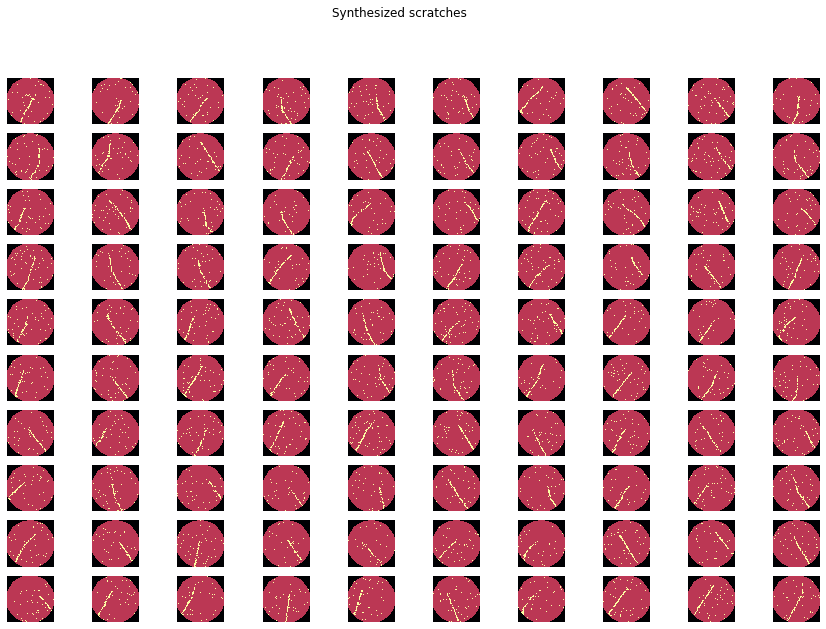

[INFO] Create scratches


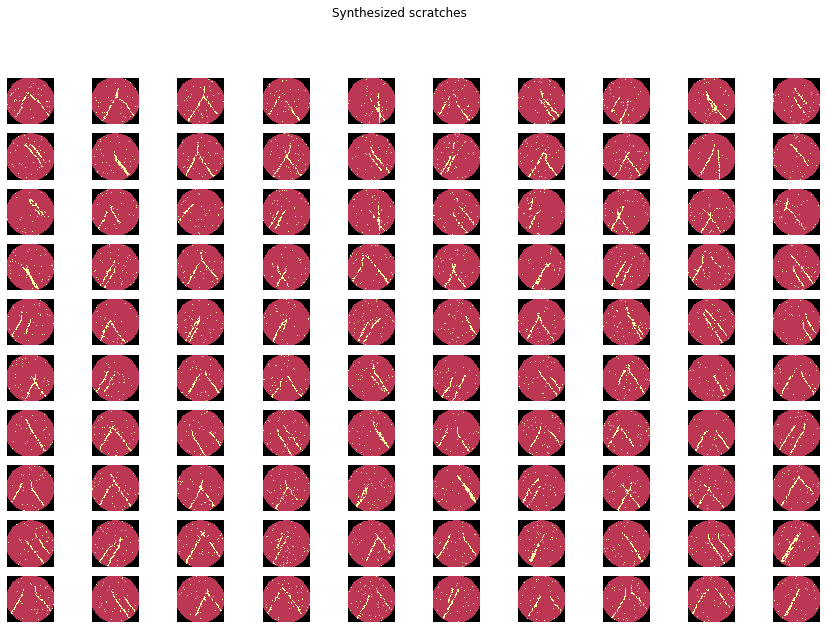

[INFO] Create scratches


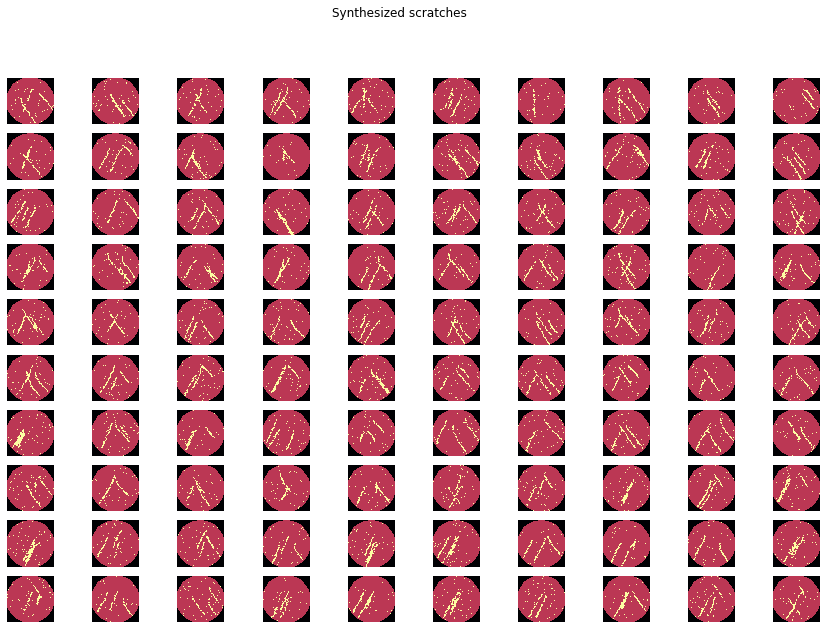

[INFO] Create scratches


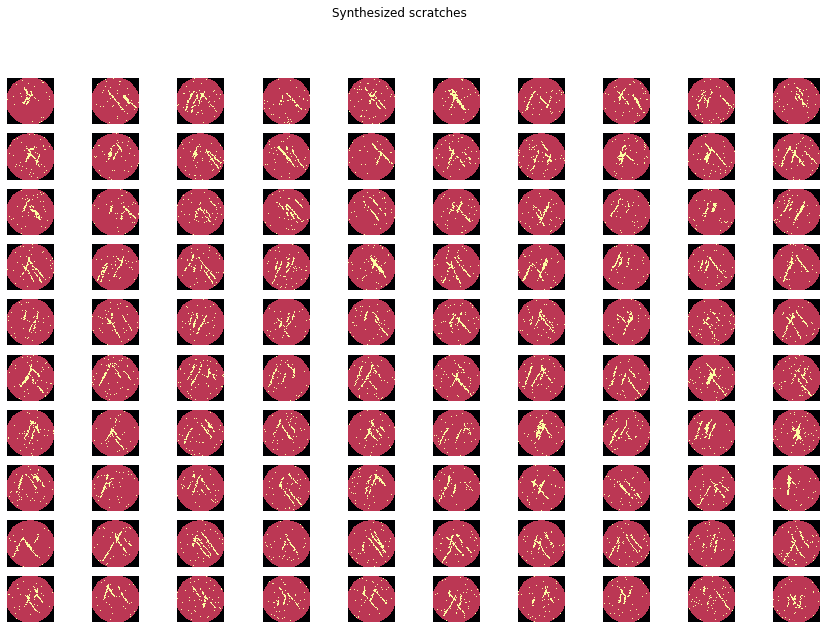

In [400]:
df_scratch_curved = [generator_scratch(mode=0, plot=True, line_count=i+1, add_patterns=[None], is_noised=True) 
                     for i in range(4)]
df_scratch_curved = pd.concat(df_scratch_curved, ignore_index=True)

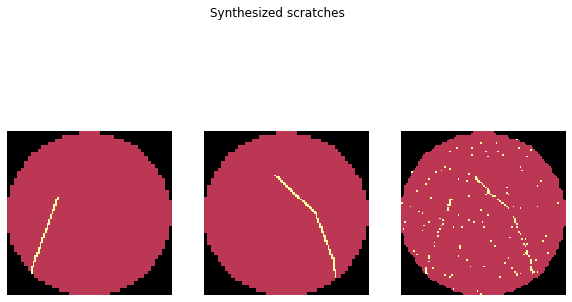

In [346]:
def add_pattern(cur_x, add_x):
    if cur_x == 1 and add_x == 2:
        return add_x
    else:
        return cur_x
add_pattern = np.vectorize(add_pattern)

sample_count = 2
test_template = deepcopy(template_map)
fig, ax = plt.subplots(nrows=1, ncols=sample_count+1, figsize=(10, 6))
ax = ax.ravel(order='C')
for i, a in enumerate(df_scratch_curved.sample(sample_count).waferMap.values):
    ax[i].imshow(a, cmap='inferno')
    ax[i].axis('off')
    test_template = add_pattern(test_template, a.copy())
    test_template = add_noise(test_template, pattern_type='scratch')
ax[i+1].imshow(test_template, cmap='inferno')
ax[i+1].axis('off')
    
fig.suptitle('Synthesized scratches')
plt.show()


# Тест для Donut

In [401]:
def create_rings(XC, YC, R_, PHI, N, pattern_type, lam_poisson=1.2, save=False, add_patterns=[None]):
    color_scale = 2
    size = XC.shape[0]
    synthesized_base = [None] * size

    for n in tqdm(range(size)):
        # тестовый полигон
        template = deepcopy(template_map)
        
        if len(add_patterns):
            for pattern in add_patterns:
                template = add_pattern(template, pattern)
        
        # параметры кольца
        phi = np.linspace(PHI[n][0], PHI[n][1], N[n])
        r = np.linspace(R_[n][0], R_[n][1], N[n])
        xc = XC[n]
        yc = YC[n]

        # синтез сетки
        R, Fi = np.meshgrid(r, phi)
        X = R * (np.cos(Fi)) + xc
        Y = R * (np.sin(Fi)) + yc
        X_ = np.around(X)
        Y_ = np.around(Y)

        # индексы для полигона
        points = []
        for i in range(X_.shape[0]):
            for j in range(X_.shape[1]):
                x = X_[i, j]
                y = Y_[i, j]
                points.append((x, y))

        for idx in points:
            i, j = idx
            i = int(round(i))
            j = int(round(j))
            try:
                if template[i, j] == 1:
                    template[i, j] = color_scale
            except IndexError:
                break

        synthesized_base[n] = [template, pattern_type]

        # для презентации
        if save:
            path = 'output/test_classes/{}'.format(pattern_type)
            try:
                os.mkdir(path)
            except OSError:
                pass
            plt.imshow(noise_img, cmap='inferno')
            name = '/{}{}.jpg'.format(pattern_type, n)
            plt.savefig(path + name)

    return pd.DataFrame(synthesized_base, columns=['waferMap', 'failureType'])

In [406]:
def generator_donut(mode=0, plot=False, add_patterns=None, is_noised=False):
    
    print('[INFO] Create donuts')
    # число синтезированных карт
    N_POINTS = number_points

    PHI = None
    for i in range(4):
        # угол старта для сектора
        phi1 = np.random.uniform(0 + 95 * i, 30 + 95 * i, size=N_POINTS // 4) * np.pi / 180
        # угол конца для сектора
        phi2 = np.random.uniform(320 + 90 * i, 360 * (i + 1), size=N_POINTS // 4) * np.pi / 180
        phi = np.vstack((phi1, phi2))
        # merge под формат генератора
        phi = np.array([[phi[0, j], phi[1, j]] for j in range(phi.shape[1])])
        if i == 0:
            PHI = phi
        else:
            PHI = np.vstack((PHI, phi))

    # радиус внутреннего круга
    r1 = np.random.randint(0.24 * IMAGE_DIMS[0], 0.26 * IMAGE_DIMS[0], size=N_POINTS)
    # радиус внешнего круга
    r2 = np.random.randint(0.3 * IMAGE_DIMS[0], 0.35 * IMAGE_DIMS[0], size=N_POINTS)
    r = np.vstack((r1, r2))
    # merge под формат генератора
    r = np.array([[r[0, i], r[1, i]] for i in range(r.shape[1])])

    # X координата старта прямой
    XC = np.random.randint(0.22 * IMAGE_DIMS[0], 0.65 * IMAGE_DIMS[0], size=N_POINTS)
    # Y координата старта прямой
    YC = np.random.randint(0.22 * IMAGE_DIMS[0], 0.65 * IMAGE_DIMS[0], size=N_POINTS)

    # интесивность
    N = np.random.randint(200, 210, size=N_POINTS)

    df_donut = None
    if mode == 0:
        # генератор параллельный
        n_workers = cpu_count
        results = Parallel(n_workers)(
            delayed(create_rings)(XC[i::n_workers], YC[i::n_workers],
                                       r[i::n_workers], PHI[i::n_workers],
                                       N[i::n_workers], pattern_type='Donut')
            for i in range(n_workers))

        df_donut = results[0]
        for i in range(1, len(results)):
            df_donut = pd.concat((df_donut, results[i]), sort=False)
    
    if is_noised:
        df_donut.waferMap = df_donut.waferMap.map(lambda wafer_map: add_noise(wafer_map, 
                                                                              pattern_type='scratch', 
                                                                              lam_poisson=0.3))

    if plot:
        fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 8))
        ax = ax.ravel(order='C')
        sample_idx = np.random.choice(N_POINTS, 100)
        for i, idx in enumerate(sample_idx):
            ax[i].imshow(df_donut.waferMap.values[idx], cmap='inferno')
            ax[i].axis('off')
        fig.suptitle('Synthesized scratches')
        plt.show()
    else:
        gc.collect()

    return df_donut

[INFO] Create rings


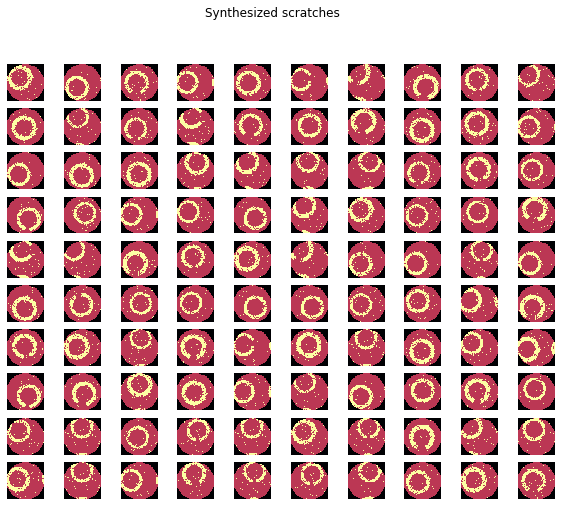

In [407]:
df_donut = generator_donut(mode=0, plot=True, add_patterns=[None], is_noised=True)